<a href="https://colab.research.google.com/github/yahia-kplr/Statistics-With-Python_fr/blob/main/Solution/6_Statistial_Experiments_and_Significance_Testing.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Expériences statistiques et tests de signification**


# **Exemple : adhérence du Web**
- Une entreprise vendant un service à valeur relativement élevée veut tester lequel des deux sites Web présentations fait un meilleur travail de vente.
- En raison de la valeur élevée du service étant vendues, les ventes sont peu fréquentes et le cycle de vente est long ; il faudrait trop de temps pour
accumulez suffisamment de ventes pour savoir quelle présentation est la meilleure.
- Alors la société décide de mesurer les résultats avec une variable proxy, en utilisant l'intérieur détaillé page qui décrit le service.
- Une variable indirecte potentielle pour notre entreprise est le nombre de clics sur la page de destination détaillée. Un meilleur est le temps que les gens passent sur la page.
- Il est raisonnable de penser qu'une présentation web (page) qui retient l'attention des gens plus longtemps conduira à plus de ventes.

- Par conséquent, notre métrique est le temps de session moyen, comparant la page A à la page B.


**Importer les packages Python requis**


In [ ]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [ ]:
WEB_PAGE_DATA_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/web_page_data.csv'
FOUR_SESSIONS_CSV ='https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/four_sessions.csv'
CLICK_RATE_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/click_rates.csv'
IMANISHI_CSV = 'https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/master/data/imanishi_data.csv'

**Rééchantillonnage**


In [ ]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

- Étant donné qu'il s'agit d'une page intérieure à usage spécial, elle ne reçoit pas de grand nombre de visiteurs.
- Notez également que Google Analytics, qui nous permet de mesurer le temps de session, ne peut pas mesurer le temps de session pour la dernière session d'une personne visites.
- Au lieu de supprimer cette session des données, GA l'enregistre en tant que
zéro, les données nécessitent donc un traitement supplémentaire pour supprimer ces sessions.
- Le résultat est un total de 36 sessions pour les deux présentations différentes, 21 pour la page A et 15 pour la page B.

- **En utilisant boxplot, nous pouvons comparer visuellement les temps de session en utilisant des boîtes à moustaches côte à côte :**


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


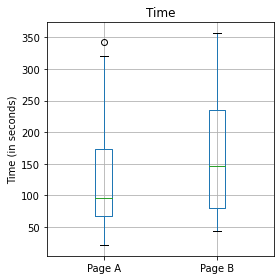

In [ ]:
ax = session_times.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

- Le boxplot, indique que la page B mène à des sessions plus longues
que la page A. Les moyennes pour chaque groupe peuvent être calculées comme suit :


In [ ]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


- La page B a des durées de session supérieures, en moyenne, de 35.66 secondes par rapport à la page A.
- la question est de savoir si cette différence se situe dans la fourchette de ce qu'est le hasard pourrait produire ou, alternativement, est statistiquement significatif.
- Une façon de répondre à ça est d'appliquer un test de permutation - combiner tous les temps de session ensemble, puis mélangez-les à plusieurs reprises et divisez-les en groupes de 21 (rappelez-vous que n = 21 pour la page
A) et 15 (n = 15 pour B).
- Pour appliquer un test de permutation, nous avons besoin d'une fonction pour assigner aléatoirement la 36 session fois à un groupe de 21 (page A) et un groupe de 15 (page B) :


In [ ]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-13.590476190476181


- cette fonction fonctionne en échantillonnant sans remise n2 indices et en affectant les au groupe B; les n1 indices restants sont affectés au groupe A.
- Les différence entre les deux moyennes est renvoyée.
- Appel de cette fonction R = 1 000 fois et en spécifiant n2  et n1  conduit à une distribution des différences dans les temps de session qui peuvent être tracés sous forme d'histogramme.


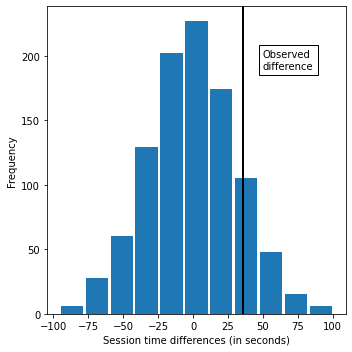

In [ ]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- L'histogramme montre que la différence moyenne des
permutations dépasse souvent la différence observée dans les temps de session (la ligne verticale).
- Cela suggère que la différence de temps de session observée entre la page A
et la page B est bien dans la plage de variation aléatoire, donc n'est pas statistiquement important.


In [ ]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.121


** Signification statistique et valeurs P**


- La signification statistique est la façon dont les statisticiens mesurent si une expérience (ou
même une étude des données existantes) donne un résultat plus extrême que ce que le hasard pourrait produire.
- Si le résultat est au-delà du domaine de la variation aléatoire, on dit qu'il est statistiquement significatif.


![image](https://user-images.githubusercontent.com/123748165/222194509-c1d4cae4-138e-400d-b72e-09b6b0079b67.png)


- Le prix A convertit presque 5 % mieux que le prix B (0,8425 % contre 0,8057 %
une différence de 0,0368 point de pourcentage), suffisamment important pour être significatif dans une entreprise à volume élevé.
- Nous avons plus de 45 000 points de données ici, et il est tentant de
considérez cela comme du "big data", ne nécessitant pas de tests de signification statistique (nécessaire principalement pour tenir compte de la variabilité d'échantillonnage dans les petits échantillons).
- Cependant, le les taux de conversion sont si faibles (moins de 1 %) que les valeurs significatives réelles —les conversions - ne sont que dans les centaines, et la taille de l'échantillon nécessaire est vraiment
déterminée par ces conversions.
- Nous pouvons tester si la différence de
les conversions entre les prix A et B se situent dans la plage de variation aléatoire, en utilisant une procédure de rééchantillonnage.
- Par « variation aléatoire », nous entendons la variation aléatoire
produit par un modèle de probabilité qui incarne l'hypothèse nulle qu'il n'y a pas différence entre les taux


En réutilisant la fonction **perm_fun** , nous pouvons
créez un histogramme des différences permutées de manière aléatoire dans le taux de conversion :


Observed difference: 0.0368%


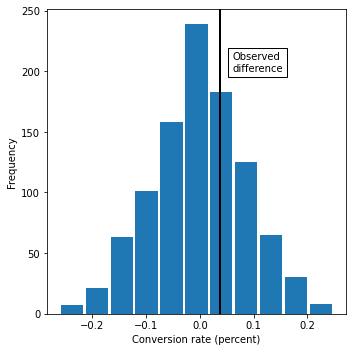

In [ ]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

la différence observée de 0,0368 % est bien dans la fourchette du hasard
variation.


**Valeur P**


- Le simple fait de regarder le graphique n'est pas un moyen très précis de mesurer les statistiques signification, donc la valeur p est plus intéressante.
- C'est la fréquence avec laquelle
le modèle aléatoire produit un résultat plus extrême que le résultat observé.

- Nous pouvons estimer une valeur p à partir de notre test de permutation en prenant la proportion de fois que le test de permutation produit une différence égale ou supérieure à la valeur observée différence:


Si np.mean est appliqué à une liste de booléens, il donne le pourcentage de la fréquence à laquelle True a été trouvé dans la liste (#True / #Total).


In [ ]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [ ]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


L'approximation normale donne une valeur de p de 0,3498, ce qui
est proche de la valeur de p obtenue à partir du test de permutation.


**Tests-t**


- Il existe de nombreux types de tests de signification, selon que les données
comprend les données de comptage ou les données mesurées, le nombre d'échantillons et ce qui est
étant mesuré.
- Un très courant est le test t, nommé d'après la distribution t de Student, développé à l'origine par W. S.
- Gossett pour approximer la distribution
moyenne d'un seul échantillon


- Tous les tests de signification nécessitent que vous spécifiez une statistique de test pour mesurer l'effet qui vous intéresse et vous aide à déterminer si cet effet observé se situe dans la plage de variation normale du hasard.
- Dans un test de rééchantillonnage , l'échelle des données n'a pas d'importance.
- Vous créez la distribution de référence (hypothèse nulle) à partir des données elles-mêmes,
et utilisez la statistique de test telle quelle.
- Dans les années 1920 et 1930, lorsque les tests d'hypothèses statistiques étaient en cours de développement, il n'était pas possible de mélanger aléatoirement des données des milliers de fois pour faire un rééchantillonnage
test.
- Les statisticiens ont découvert qu'une bonne approximation de la permutation (mélangée) distribution était le test t, basé sur la distribution t de Gossett. Il est utilisé pour le très comparaison commune à deux échantillons — test A/B — dans laquelle les données sont numériques.
- Mais pour que la distribution t soit utilisée sans tenir compte de l'échelle, une forme de la statistique de test doit être utilisée.
- Un texte de statistique classique montrerait à ce stade diverses formules qui intègrent la distribution de Gossett et montrez comment normaliser vos données pour les comparer à la distribution t standard.
- Ces formules ne sont pas présentées ici car tous les logiciels statistiques, ainsi que R et Python, incluent des commandes qui incarnent le formule.
- Dans Python, la fonction est stats.ttest_ind :


In [ ]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time, 
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


- L'hypothèse alternative est que le temps de session moyen pour la page A est inférieur à celui pour la page B.
- La valeur p de 0,1408 est assez proche des valeurs p du test de permutation de
0,121 et 0,126 .
- Dans un mode de rééchantillonnage, nous structurons la solution pour refléter les données observées et les hypothèse à tester, sans se soucier de savoir si les données sont numériques ou binaires,que les tailles d'échantillon soient équilibrées ou non, les variances d'échantillon ou une variété d'autres facteurs
teurs. Dans le monde des formules, de nombreuses variations se présentent, et elles peuvent êtreTests t | 111
déconcertant.
- Les statisticiens doivent naviguer dans ce monde et apprendre sa carte, mais la science des données les entistes ne le font pas - ils ne sont généralement pas chargés de transpirer les détails de tests d'hypothèses et intervalles de confiance comme un chercheur préparant un article pour présentation pourrait.


In [ ]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


**ANOVA**


- Supposons qu'au lieu d'un test A/B, nous ayons une comparaison de plusieurs groupes, disons A/B/C/D, chacun avec des données numériques.
- La procédure statistique qui teste une statistique différence significative entre les groupes est appelée analyse de variance, ou ANOVA.
![image](https://user-images.githubusercontent.com/123748165/222193725-0de37f1d-add9-468f-a185-579b183a8194.png)


- Ce tableau montre la viscosité de quatre pages Web, définie comme le nombre de secondes par visiteur passé sur la page.
- Les quatre pages sont désactivées afin que chaque visiteur du site
en reçoit un au hasard.
- Il y a un total de cinq visiteurs pour chaque page, et dans ce Table , chaque colonne est un ensemble de données indépendant.
- Le premier spectateur de la page 1 a pas de connexion au premier visualiseur pour la page 2.
- Notez que dans un test web comme celui‐ci, nous pouvons‐
ne met pas pleinement en œuvre le plan d'échantillonnage aléatoire classique dans lequel chaque visiteur est choisis au hasard parmi une immense population.
- Il faut prendre les visiteurs comme ils viens.
- Les visiteurs peuvent systématiquement différer selon l'heure de la journée, la période de la semaine, la mer.
- fils de l'année, les conditions de leur connexion Internet, l'appareil qu'ils utilisent, etc.

- Ces facteurs doivent être considérés comme un biais potentiel lorsque les résultats de l'expérience sont
revu.


- Nous avons maintenant une énigme (voir Figure 3-6). Lorsque nous comparions seulement deux groupes, c'était simple; nous avons simplement regardé la différence entre les moyens
de chaque groupe.
- Avec quatre moyennes, il y a six comparaisons possibles entre les groupes :

- Page 1 par rapport à la page 2

- Page 1 par rapport à la page 3

- Page 1 par rapport à la page 4

- Page 2 par rapport à la page 3

- Page 2 par rapport à la page 4

- Page 3 par rapport à la page 4

- Plus nous faisons de telles comparaisons par paires, plus le potentiel d'être
trompé par hasard.
- Au lieu de s'inquiéter sur toutes les différentes comparaisons entre les pages individuelles que nous pourrions éventuellement faire, nous pouvons faire un seul test global qui répond à la question, "Toutes les pages pourraient-elles avoir la même adhérence sous-jacente, et les différences entre elles sont dues à la façon dont un ensemble commun de temps de session a été réparti entre les quatre pages ? »


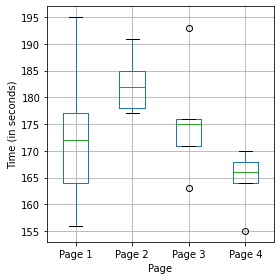

In [ ]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [ ]:
print(pd.read_csv(FOUR_SESSIONS_CSV).head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


- La procédure utilisée pour tester cela est ANOVA. La base pour cela peut être vue dans ce qui suit procédure de rééchantillonnage (spécifiée ici pour le test A/B/C/D de la page Web collant):
1. Combinez toutes les données ensemble dans une seule case.
2. Mélangez et tirez quatre rééchantillons de cinq valeurs chacun.
3. Enregistrez la moyenne de chacun des quatre groupes.
4. Enregistrez la variance entre les moyennes des quatre groupes.
5. Répétez les étapes 2 à 4 plusieurs (disons, 3 000) fois.


- la fonction perm_test calcule un test de permutation pour ce cas:


In [ ]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
82.04


Pr(Prob) 0.07766666666666666


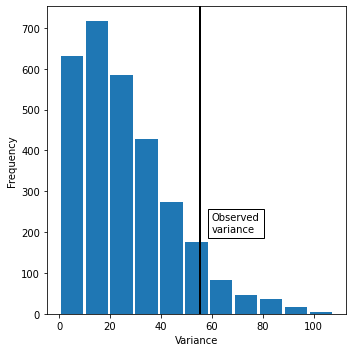

In [ ]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- La valeur de p, donnée par Pr(Prob), est de 0,07766. En d'autres termes, étant donné la même adhérence sous-jacente, 7,8 % du temps, le taux de réponse sur quatre pages peut différer selon autant qu'on l'a effectivement observé, juste par hasard. Ce degré d'improbabilité tombe en deçà du seuil statistique traditionnel de 5 %, nous concluons donc que la différence parmi les quatre pages aurait pu surgir par hasard.
- La colonne Iter répertorie le nombre d'itérations prises dans le test de permutation.
-  les autres colonnes correspondent à une table ANOVA traditionnelle et sont décrites ci-après.
